## Матан, градиентный спуск через DAG / Calculus, gradient descent, DAG.

In [66]:
import torch
import matplotlib.pyplot as plt

#### 1.Зададим и нарис исходные данные(тут просто x-прием лекарства от y-результат после лекарства)

In [3]:
#дозы лекарства против болезни Альцгеймера
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) 
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

In [4]:
#параметр забывчивости  после каждой дозы
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) 
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

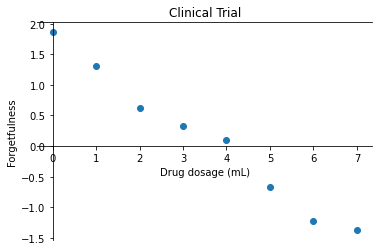

In [41]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")


# set the x-spine
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

_ = ax.scatter(x, y)

Ок, видим что лекарство работает. Люди забывают меньше после каждого приема. И зависимость почти идеально линейная. Значит задача - построить линейную регрессию, только сначала надо найти веса. Это можно сделать через множество споcобов(мура-пенроуза, наименьших квадратов, максимального правдоподобия итд, но тут задача - сделать это через градиентный спуск. И тому есть веская причина. Град спуск оч хорош, когда у нас очень много фичей, т.е. когда-то потом в нейронках это пригодится. <br>
Поехали.

#### 2. Чтобы начать град спуск - надо от балды построить какое-то любое предсказание. Чтобы алгоритм мог от чего-то отталкиваться. У нас линейная регрессия - значит построим рандомную линию предсказания.

Вспомним как построить линию:<br>
Получается возьмем рандомные m,b

![Screenshot](line.png)

In [18]:
#m=возьмем 0.9, required_grad= pytorch будет следить за изменением этого параметра
m=torch.tensor([0.9]).requires_grad_()

In [19]:
b=torch.tensor([0.1]).requires_grad_()

In [20]:
#построим формулу линии через ф-цию
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [43]:
#нарисуем наше рандомное предсказание
def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots() #построить пустую систему координат

    ax.scatter(my_x, my_y) #построить скаттер-граф, т.е. завис x от y
    
    x_min, x_max = ax.get_xlim() #Границы оси x
    y_min = regression(x_min, my_m, my_b) #Границы оси y
    y_max = regression(x_max, my_m, my_b)
    
    
    
    #этот кусок кода делает точку пересечения 0,0, а не какую-то хренатеть
    # set the x-spine
    ax.spines['left'].set_position('zero')
    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()
    # set the y-spine
    ax.spines['bottom'].set_position('zero')
    
    
    
    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

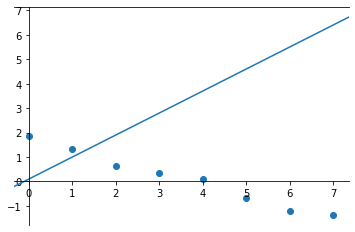

In [44]:
regression_plot(x, y, m, b)

Ок, мы создали рандомное предсказание.

#### 3. Нарисуем наш DAG и будем по нему двигаться
DAG-как бы наш один проход, на котором мы найдем чуть лучшие m,b

![Screenshot](DAG.png)

#### 4. Step1 from our DAG = forward pass

y с кепкой= наше предсказанное значение.<br>
Идея forward pass - поставить какие-то m,b(в нашем случае наши рандомные, которые мы делали чуть выше) и получить y с кепкой для каждой точки x.<br> Т.е. для каждой точки x - есть точка y, а мы найдем y с кепкой для каждой точки х.

In [28]:
yhat=regression(x,m,b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

#### 4. Step2 from our DAG = compare, или подсчет Cost function

Идея compare-сравнить насколько отличается наше y с кепкой, от реального y. Т.е. насколько точно наше предсказание.<br>
Сравнивать можно разными формулами, их много разных. Все они назыавются формулы подсчета ошибки или по забугорному Cost function или Lost function. Но нам надо какую-то одну из них выбрать. Возьмем MSE.<br>
Вообще эти формулы выбирают не от балды, а преследуя цели - насколько сильно мы должны наказывать алгоритм за ошибки или еще что-то.<br>
В нашем случае MSE - юзается из того что я знаю, когда надо подсветить большие ошибки - она их возведет в квадрат и они станут более заметными.

Вспомним что такое MSE на рандомном примере:<br>
![Screenshot](MSE.png)

In [33]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [34]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

#### 5. Step3 from DAG = идем назад=находим улучшенное C,m,b

FYI: Это всего пару строчек кода, но там очень много чего под капотом. Глубже разбор будет чуть ниже

In [40]:
C.backward() #сходить обратно

RuntimeError: Trying to backward through the graph a second time (or directly access saved variables after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved variables after calling backward.

In [36]:
m.grad

tensor([36.3050])

In [45]:
b.grad

tensor([6.2650])

#### 6. Step4 from DAG = Градиентный спуск на один шажок

In [47]:
optimizer = torch.optim.SGD([m, b], lr=0.01) #подаем на вход наши m,b  lr=наш размер шажка в град спуске

In [48]:
optimizer.step() #находим чуть лучшие m,b путем град спуска на 1 шажок

In [51]:
m #видим,что m оч сильно поменялось

tensor([0.5369], requires_grad=True)

In [50]:
b #видим, что и b тоже поменялось

tensor([0.0374], requires_grad=True)

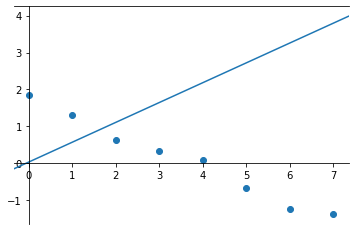

In [53]:
regression_plot(x,y,m,b)

Итог: я вижу, что линия стала чуть более точной за счет новых m,b. Но толку пока мало, линия предсказания как была очень неточной, так в принципе ей и осталось

#### 7. Step4 from DAG = Но только теперь все шажки до низу сразу. Т.е. будем  повторять Step1,2,3,4 from DAG много раз и посмотрим результат

In [55]:
epochs = 1000
for epoch in range(epochs):
    
    optimizer.zero_grad() # Reset gradients to zero; else they accumulate
    
    yhat = regression(x, m, b) # Step 1
    C = mse(yhat, y) # Step 2
    
    C.backward() # Step 3
    optimizer.step() # Step 4
    
    print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, cost 8.57, m grad 23.2, b grad 3.6
Epoch 1, cost 4.08, m grad 14.8, b grad 1.91
Epoch 2, cost 2.25, m grad 9.49, b grad 0.831
Epoch 3, cost 1.51, m grad 6.11, b grad 0.15
Epoch 4, cost 1.2, m grad 3.96, b grad -0.28
Epoch 5, cost 1.07, m grad 2.59, b grad -0.552
Epoch 6, cost 1.01, m grad 1.72, b grad -0.723
Epoch 7, cost 0.981, m grad 1.17, b grad -0.829
Epoch 8, cost 0.962, m grad 0.82, b grad -0.894
Epoch 9, cost 0.948, m grad 0.595, b grad -0.934
Epoch 10, cost 0.936, m grad 0.452, b grad -0.957
Epoch 11, cost 0.925, m grad 0.361, b grad -0.969
Epoch 12, cost 0.915, m grad 0.302, b grad -0.975
Epoch 13, cost 0.904, m grad 0.265, b grad -0.977
Epoch 14, cost 0.894, m grad 0.241, b grad -0.976
Epoch 15, cost 0.884, m grad 0.225, b grad -0.973
Epoch 16, cost 0.874, m grad 0.214, b grad -0.969
Epoch 17, cost 0.864, m grad 0.207, b grad -0.965
Epoch 18, cost 0.854, m grad 0.202, b grad -0.96
Epoch 19, cost 0.845, m grad 0.199, b grad -0.955
Epoch 20, cost 0.835, m grad 0.196, b

Epoch 282, cost 0.0589, m grad 0.0425, b grad -0.209
Epoch 283, cost 0.0584, m grad 0.0422, b grad -0.208
Epoch 284, cost 0.058, m grad 0.042, b grad -0.207
Epoch 285, cost 0.0575, m grad 0.0418, b grad -0.205
Epoch 286, cost 0.0571, m grad 0.0415, b grad -0.204
Epoch 287, cost 0.0567, m grad 0.0413, b grad -0.203
Epoch 288, cost 0.0562, m grad 0.041, b grad -0.202
Epoch 289, cost 0.0558, m grad 0.0408, b grad -0.201
Epoch 290, cost 0.0554, m grad 0.0406, b grad -0.199
Epoch 291, cost 0.055, m grad 0.0403, b grad -0.198
Epoch 292, cost 0.0546, m grad 0.0401, b grad -0.197
Epoch 293, cost 0.0542, m grad 0.0399, b grad -0.196
Epoch 294, cost 0.0538, m grad 0.0396, b grad -0.195
Epoch 295, cost 0.0534, m grad 0.0394, b grad -0.194
Epoch 296, cost 0.053, m grad 0.0392, b grad -0.193
Epoch 297, cost 0.0526, m grad 0.039, b grad -0.192
Epoch 298, cost 0.0522, m grad 0.0387, b grad -0.19
Epoch 299, cost 0.0519, m grad 0.0385, b grad -0.189
Epoch 300, cost 0.0515, m grad 0.0383, b grad -0.188


Epoch 591, cost 0.0206, m grad 0.00712, b grad -0.035
Epoch 592, cost 0.0206, m grad 0.00708, b grad -0.0348
Epoch 593, cost 0.0205, m grad 0.00704, b grad -0.0346
Epoch 594, cost 0.0205, m grad 0.00699, b grad -0.0344
Epoch 595, cost 0.0205, m grad 0.00695, b grad -0.0342
Epoch 596, cost 0.0205, m grad 0.00691, b grad -0.034
Epoch 597, cost 0.0205, m grad 0.00687, b grad -0.0338
Epoch 598, cost 0.0205, m grad 0.00684, b grad -0.0336
Epoch 599, cost 0.0205, m grad 0.0068, b grad -0.0334
Epoch 600, cost 0.0205, m grad 0.00676, b grad -0.0332
Epoch 601, cost 0.0205, m grad 0.00672, b grad -0.033
Epoch 602, cost 0.0204, m grad 0.00668, b grad -0.0328
Epoch 603, cost 0.0204, m grad 0.00664, b grad -0.0327
Epoch 604, cost 0.0204, m grad 0.0066, b grad -0.0325
Epoch 605, cost 0.0204, m grad 0.00656, b grad -0.0323
Epoch 606, cost 0.0204, m grad 0.00653, b grad -0.0321
Epoch 607, cost 0.0204, m grad 0.00649, b grad -0.0319
Epoch 608, cost 0.0204, m grad 0.00645, b grad -0.0317
Epoch 609, cost

Epoch 899, cost 0.0195, m grad 0.0012, b grad -0.0059
Epoch 900, cost 0.0195, m grad 0.00119, b grad -0.00586
Epoch 901, cost 0.0195, m grad 0.00119, b grad -0.00583
Epoch 902, cost 0.0195, m grad 0.00118, b grad -0.0058
Epoch 903, cost 0.0195, m grad 0.00117, b grad -0.00576
Epoch 904, cost 0.0195, m grad 0.00116, b grad -0.00573
Epoch 905, cost 0.0195, m grad 0.00116, b grad -0.0057
Epoch 906, cost 0.0195, m grad 0.00115, b grad -0.00566
Epoch 907, cost 0.0195, m grad 0.00114, b grad -0.00563
Epoch 908, cost 0.0195, m grad 0.00114, b grad -0.0056
Epoch 909, cost 0.0195, m grad 0.00113, b grad -0.00557
Epoch 910, cost 0.0195, m grad 0.00113, b grad -0.00553
Epoch 911, cost 0.0195, m grad 0.00112, b grad -0.0055
Epoch 912, cost 0.0195, m grad 0.00111, b grad -0.00547
Epoch 913, cost 0.0195, m grad 0.00111, b grad -0.00544
Epoch 914, cost 0.0195, m grad 0.0011, b grad -0.00541
Epoch 915, cost 0.0195, m grad 0.00109, b grad -0.00538
Epoch 916, cost 0.0195, m grad 0.00109, b grad -0.00535

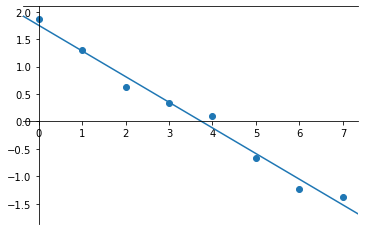

In [57]:
regression_plot(x, y, m, b)

In [59]:
m #какое m после 1000сячи прогонов

tensor([-0.4681], requires_grad=True)

In [60]:
b #какое b после 1000сячи прогонов

tensor([1.7543], requires_grad=True)

Итог: после 1000сячи прогонов, у он очень хороший результат

#### Additional step. Explanations of DAG step 3 или что было под капотом в step3

Вспомним что было в step 3, мы там ходили обратно. Что это значит, как это считать?
Не уверен, что все верно понял, но как-то так

Нам надо улучшисть C(cost function).<br>
C будет лучше, когда наша линия предсказания станет точнее. <br>
Наша линия предсказания станет точнее, когда m,b станут точнее. <br>
Сделать их точнее можно через производную, но алгоритм не может считать точность когди и m и b меняются. Надо что-то одно зафиксировать, посчитать производную, потом наоборот - зафиксировать 2ой параметр и посчитать производную. Для этого юзаются частные производые.<br>
А потом рез частной производн, где было зафиксировано m перемножают с рез частной производно, где было зафикировано b по правилу Chain rule для частных производных(в нашем случае для 1ой многомерной ф-ции).

Операция backward(улучшен C)=могу сказать и autodiff=reverse mode=частная производная Cost по фичам

Просто рандомный пример на autodiff:<br>
![Screenshot](autodiff.png)

Тогда что было в степе3, но посчитаем не через MSE как по идее надо было бы, а через QCF(quadratic cost function=sum of sqared erors)(суть таже, просто формула ошибки другая, не суть):
![Screenshot](Step3..png)

Формула Chain rule для multivariate function(т.е. для одной многомерной ф-ции, не 2ух, а одно как у нас):

![Screenshot](multivariate_function_partial_derivative.png)